# Exploratory Data Analysis of Vodafone dataset

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import geopandas as gpd

## Loading data

In [29]:
path = 'vodafone_age_subset.csv'
df = pd.read_csv(path)

## Data cleaning

In [30]:
df['device_type_rus'].value_counts()

device_type_rus
smartphone    15611
phone          3610
0              1779
Name: count, dtype: int64

**В описі колонок сказано, що в 'device_type_rus' повинно містити значення: смартфон, не смартфон,
планшет. Тому замінюємо '0' на 'tablet'.**

In [31]:
df['device_type_rus'] = df['device_type_rus'].replace({'0': 'tablet'})
df['device_type_rus'].value_counts()

device_type_rus
smartphone    15611
phone          3610
tablet         1779
Name: count, dtype: int64

**Видалимо колонки, які нам непотрібні**

In [32]:
df.drop(columns=['user_hash', 'target', 'device_brand', 'device_model'], inplace=True)

**Створимо функцію, яка рахує кількість нулів в кожній колонці і видалимо колонки, в яких їх багато**

In [33]:
def count_zeros(col):
  return col.apply(lambda x: str(x).strip() in {'0', '0.0'}).sum()

zero_percentage_per_column = df.apply(count_zeros) / len(df) * 100

pd.set_option('display.max_rows', None)  # sets maximum amount of rows displayed to none

print(zero_percentage_per_column)

CALCULATION_METHOD_ID            0.000000
calls_count_in_weekdays          6.900000
calls_duration_in_weekdays       6.900000
calls_count_out_weekdays         8.052381
calls_duration_out_weekdays      8.052381
calls_count_in_weekends         11.585714
calls_duration_in_weekends      11.585714
calls_count_out_weekends        14.104762
calls_duration_out_weekends     14.104762
DATA_VOLUME_WEEKDAYS            40.723810
DATA_VOLUME_WEEKENDS            44.828571
LAT_HOME                         6.166667
LON_HOME                         6.166667
Oblast_post_HOME                 6.166667
Raion_post_HOME                  6.166667
City_post_HOME                   6.166667
lat_quad_home                    6.166667
lon_quad_home                    6.166667
LAT_WORK                         4.580952
LON_WORK                         4.580952
Oblast_post_WORK                 4.580952
Raion_post_WORK                  4.580952
City_post_WORK                   4.580952
lat_quad_work                    4

In [34]:
df.drop(columns=['software_os_vendor', 'software_os_name', 'software_os_version'], inplace=True)

**В багатьох колонках присутні пропущенні значеня у вигляді нулів, тому замінимо їх на np.nan для
полегшення роботи з ними в майбутньому.**

In [35]:
df[
    ['LAT_HOME', 'LON_HOME', 'lat_quad_home', 'lon_quad_home', 'LAT_WORK',
    'LON_WORK', 'lat_quad_work', 'lon_quad_work', 'phone_value']
  ] = df[
    ['LAT_HOME', 'LON_HOME', 'lat_quad_home', 'lon_quad_home', 'LAT_WORK',
    'LON_WORK', 'lat_quad_work', 'lon_quad_work', 'phone_value']
  ].replace({0: np.nan})
df[
    ['Oblast_post_HOME', 'Raion_post_HOME', 'City_post_HOME',
    'Oblast_post_WORK', 'Raion_post_WORK', 'City_post_WORK', 'SCORING']
  ] = df[
    ['Oblast_post_HOME', 'Raion_post_HOME', 'City_post_HOME',
    'Oblast_post_WORK', 'Raion_post_WORK', 'City_post_WORK', 'SCORING']
  ].replace({'0': np.nan, '0.0' : np.nan})

## Descriptive statistics

**Створимо графік використання мобільного інтернету в різних додатках**

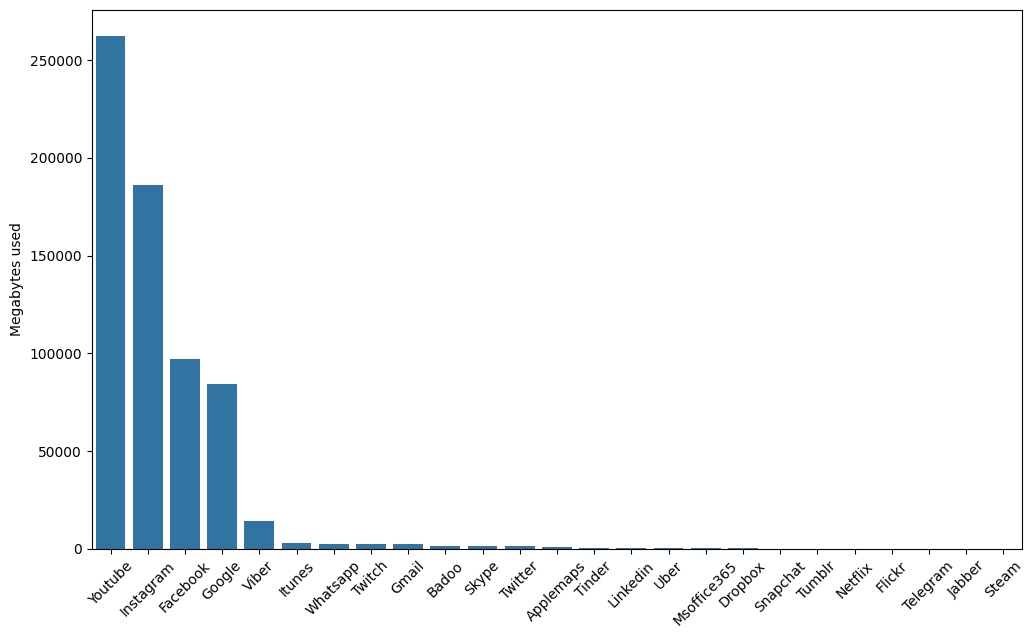

In [36]:
# Grabs every <app>_volume column starting from 'fb_volume'
internet_usage = df.iloc[:, df.columns.get_loc('fb_volume')::2]

# .str allows us to use string methods on every column of a dataframe
internet_usage.columns = internet_usage.columns.str.replace('_volume', '').str.capitalize() 
internet_usage.columns = internet_usage.columns.str.replace('Fb', 'Facebook')

# Creating a series containing the sum of data usage for each column and sorting the series
internet_sum = internet_usage.sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 7))
sns.barplot(x=internet_sum.index, y=internet_sum.values)
plt.ylabel('Megabytes used')
plt.xlabel('')
plt.xticks(rotation=45)  # Rotating labels on X axis by 45 degrees for better readability
plt.show()

**Створимо графік областей та філій відповідно до кількості опитаних абонентів,
проживаючих/працюючих в них**

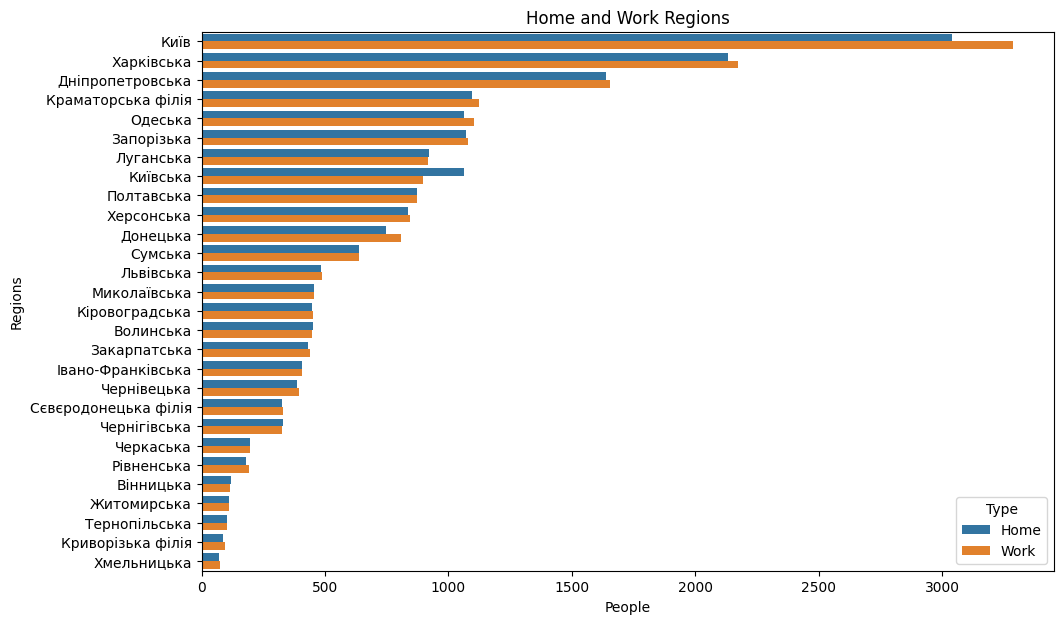

In [37]:
# Creating two series and sorting them, so that they have similar indices
home_regions = df['Oblast_post_HOME'].value_counts().sort_index()
work_regions = df['Oblast_post_WORK'].value_counts().sort_index()

# Creating a dataframe from the series and sorting it.
regions = pd.DataFrame({'Home': home_regions, 'Work': work_regions})
regions.sort_values(by='Work', ascending=False, inplace=True)

# .melt converts the dataframe to long format, resetting the index and renaming columns
regions_long = regions.reset_index().melt(id_vars='index', var_name='Type', value_name='Count')

plt.figure(figsize=(11, 7))
sns.barplot(x='Count', y='index', hue='Type', data=regions_long)
plt.xlabel('People')
plt.ylabel('Regions')
plt.title('Home and Work Regions')
plt.show()

**Створимо choropleth мапу для кращого розуміння кількості людей, які проживають в цих областях**

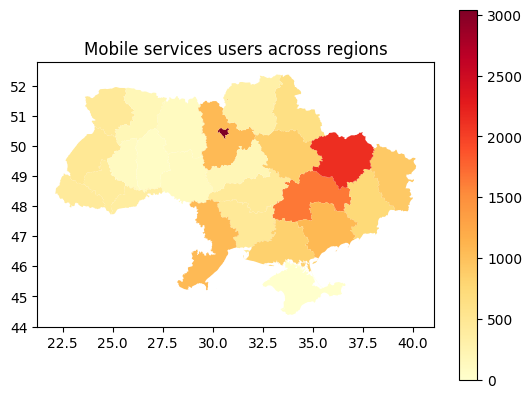

In [38]:
# Creating GeoDataFrame of Ukraine's regions
ua_path = 'ua_regions.json'
regions = gpd.read_file(ua_path)

# Mapping regions from English to Ukrainian
regions['name_mapped'] = regions['name'].map({'Avtonomna Respublika Krym': 'АР Крим',
                                       'Vinnytska': 'Вінницька',
                                       'Volynska': 'Волинська',
                                       'Dnipropetrovska': 'Дніпропетровська',
                                       'Donetska': 'Донецька',
                                       'Zhytomyrska': 'Житомирська',
                                       'Zakarpatska': 'Закарпатська',
                                       'Zaporizka': 'Запорізька',
                                       'Ivano-Frankivska': 'Івано-Франківська',
                                       'Kyivska': 'Київська',
                                       'Kirovohradska': 'Кіровоградська',
                                       'Luhanska': 'Луганська',
                                       'Lvivska': 'Львівська',
                                       'Mykolaivska': 'Миколаївська',
                                       'Odeska': 'Одеська',
                                       'Poltavska': 'Полтавська',
                                       'Rivnenska': 'Рівненська',
                                       'Sumska': 'Сумська',
                                       'Ternopilska': 'Тернопільська',
                                       'Kharkivska': 'Харківська',
                                       'Khersonska': 'Херсонська',
                                       'Khmelnytska': 'Хмельницька',
                                       'Cherkaska': 'Черкаська',
                                       'Chernivetska': 'Чернівецька',
                                       'Chernihivska': 'Чернігівська',
                                       'Kyivska': 'Київ',
                                       'Sevastopilska': 'Севастополь'
})

# Distinguishing Kyiv region from Kyiv city
regions.loc[regions['id'] == 'UA30', 'name_mapped'] = 'Київська'

# Removing non-oblast regions from the GeoDataFrame
home_regions_for_gdf = home_regions.drop(['Сєвєродонецька філія', 'Краматорська філія', 'Криворізька філія'])

# Resetting indices to merge
home_regions_for_gdf = home_regions_for_gdf.reset_index()

# Merging and plotting
merged_regions = regions.merge(home_regions_for_gdf, left_on='name_mapped', right_on='Oblast_post_HOME', how='outer')
merged_regions.fillna(0, inplace=True)

merged_regions.plot(column='count', legend=True, cmap='YlOrRd')
plt.title('Mobile services users across regions')
plt.show()

**Подивимось, скільки в середньому платить більшість користувачів за послуги на місяць**

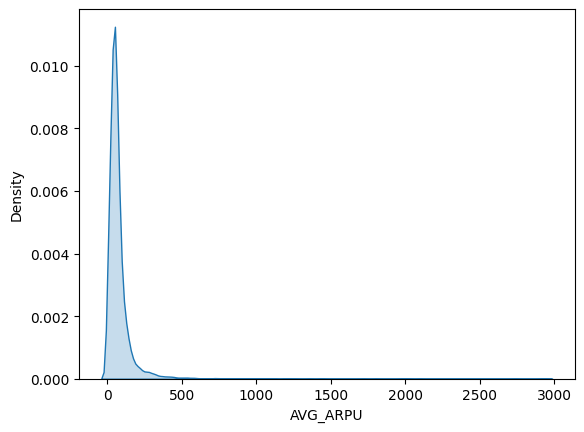

In [39]:
sns.kdeplot(df["AVG_ARPU"], fill=True)
plt.show()

In [40]:
df['AVG_ARPU'].describe()

count    21000.000000
mean        74.161760
std         99.804255
min          0.000000
25%         33.739513
50%         52.799021
75%         80.759410
max       2944.478783
Name: AVG_ARPU, dtype: float64

**(Тобто більшість користувачів витрачає в межах 30-90грн на місяць за послуги)**

**Графік тривалості користування послугами в роках**

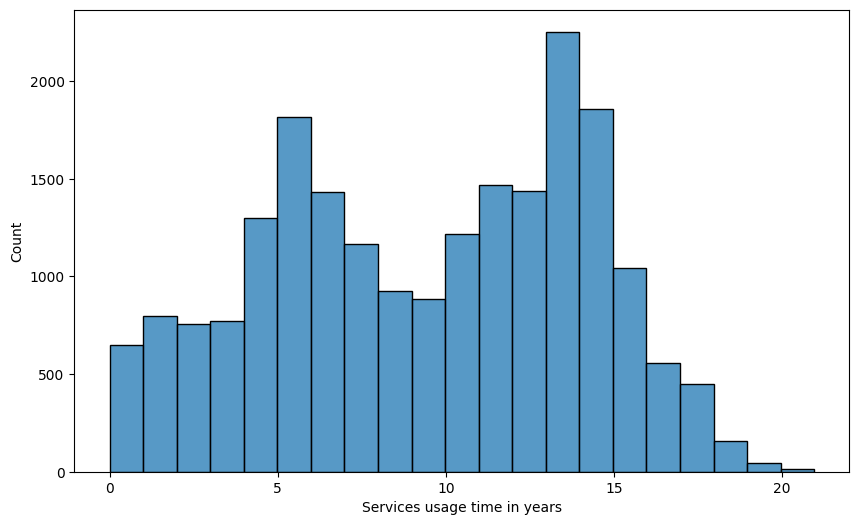

In [41]:
plt.figure(figsize=(10,6))

# Convert months to years and set the amount of 'bars'
sns.histplot(x=df['lifetime']/12, bins=21)

plt.xlabel('Services usage time in years')
plt.show()

**Графік кількості смс-повідомлень від банків**

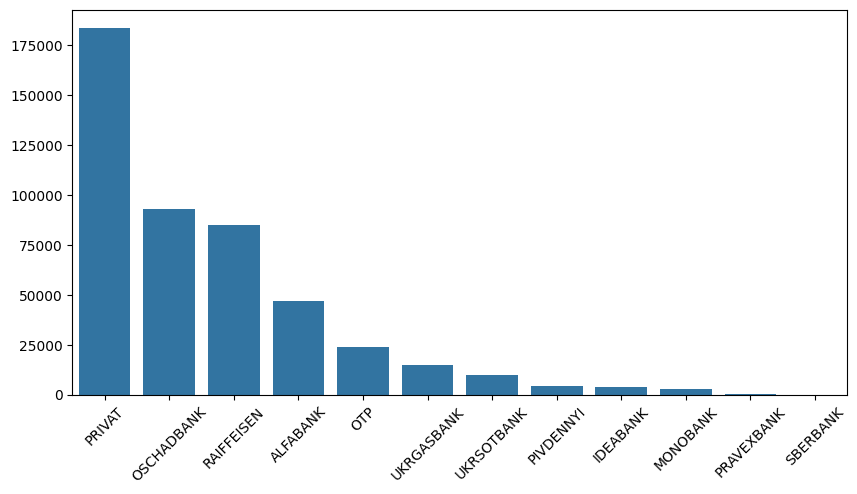

In [42]:
# Creating a dataframe of banks and sorting it
banks = df.iloc[
    :, df.columns.get_loc('PRIVAT') : df.columns.get_loc('UKRSIB')
    ].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=banks.index, y=banks.values)
plt.xlabel('')
plt.xticks(rotation=45) # Rotating labels on X axis by 45 degrees for better readability
plt.show()

**Графік кількості смс-повідомлень від заправок**

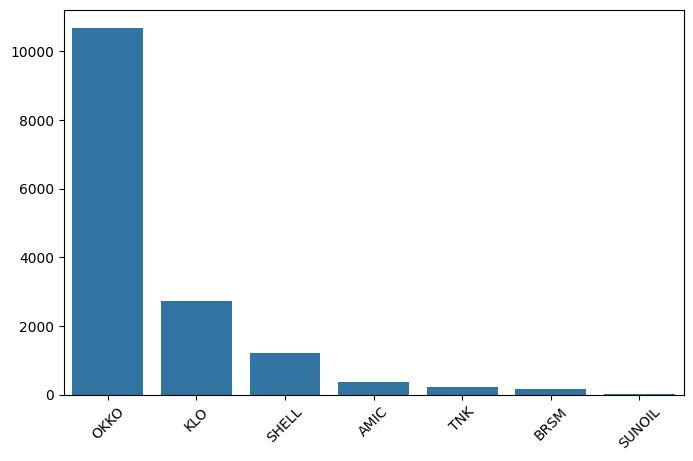

In [43]:
# Creating a dataframe of gas stations and sotring it
gas_stations = df.iloc[
    :, df.columns.get_loc('SHELL') : df.columns.get_loc('UPG')
    ].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=gas_stations.index, y=gas_stations.values)
plt.xlabel('')
plt.xticks(rotation=45) # Rotating labels on X axis by 45 degrees for better readability
plt.show()

**Зведена таблиця рівня доходу відповідно до середнього обсягу використаного 
мобільного інтернету, а також кількості вхідних та вихідних дзвінків за тиждень**

In [44]:
# Creating new columns
df['calls_count_in_week'] = df['calls_count_in_weekdays'] + df['calls_count_in_weekends']
df['calls_count_out_week'] = df['calls_count_out_weekdays'] + df['calls_count_out_weekends']
df['DATA_VOLUME_WEEK'] = df['DATA_VOLUME_WEEKDAYS'] + df['DATA_VOLUME_WEEKENDS']

# Columns to use in the pivot table
calls_and_data_columns = df[['calls_count_in_week', 'calls_count_out_week', 'DATA_VOLUME_WEEK']]

pivot_table = df.pivot_table(index='SCORING', values=calls_and_data_columns, aggfunc='mean')

# Arranging the rows of the pivot table according to the desired order
category_order = ['HIGH', 'HIGH_MEDIUM', 'MEDIUM', 'LOW', 'VERY LOW']
pivot_table = pivot_table.loc[category_order]

pivot_table

,DATA_VOLUME_WEEK,calls_count_in_week,calls_count_out_week
SCORING,,,
HIGH,219.721178,12.266652,13.041034
HIGH_MEDIUM,118.738089,10.284393,10.608609
MEDIUM,133.894365,7.997323,7.987088
LOW,38.998596,6.325680,6.922515
VERY LOW,4.162888,4.517137,5.347101


**Рівень доходу відповідно до середньої ціни послуг, використаних абонентами
протягом місяця**

In [45]:
df.groupby('SCORING')['AVG_ARPU'].agg(['min', 'mean', 'max']).loc[category_order]

,min,mean,max
SCORING,,,
HIGH,0.228758,190.638501,2914.529717
HIGH_MEDIUM,0.000000,85.656545,2735.553392
MEDIUM,0.000000,65.718774,2944.478783
LOW,0.000000,40.715328,723.586667
VERY LOW,0.000000,28.170659,55.999683


**Подивимось, чи якась стать більш схильна до онлайн купівель**

In [46]:
df.pivot_table(index='gender', values='ecommerce_score', aggfunc='mean')

,ecommerce_score
gender,
0,0.302986
1,0.264584


*Чоловіки трохи більш схильні до онлайн купівель*

**Подивимось, чи є різниця між наявністю машини у чоловіків і жінок**

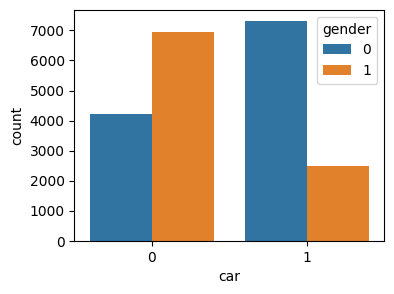

In [47]:
plt.figure(figsize=(4,3))
sns.countplot(x=df['car'], hue=df['gender'])
plt.show()

## Correlation Analysis

**Перевіримо наявність залежності між значеннями різних колонок**

In [48]:
# nan_policy='omit' skips the rows if there is a null value in it
print(spearmanr(df['AVG_ARPU'], df['phone_value'], nan_policy='omit'))

SignificanceResult(statistic=-0.3716759429168927, pvalue=0.0)


*Присутня помірна залежність між середньою ціною послуг та вартістю телефона: чим
більша ціна послуг - тим дорожча категорія телефона у абонента.
(Показник залежності є негативним, так як більш дорогій категорії телефону відповідає 
менше число: 1 - найдорожча категорія, 4 - найдешевша)*

In [49]:
print(spearmanr(df['calls_count_in_weekdays'] + df['calls_count_out_weekdays'],
                df['calls_count_in_weekends'] + df['calls_count_out_weekends'],
                nan_policy='omit'))

SignificanceResult(statistic=0.8737928522138951, pvalue=0.0)


*Присутня дуже сильна залежність між кількістю дзвінків у робочі і вихідні дні: ті,
хто багато дзвонять у робочі дні - багато дзвонять і у вихідні.*

In [50]:
print(spearmanr(df['calls_count_in_week'] + df['calls_count_out_week'],
                df['DATA_VOLUME_WEEK'],
               nan_policy='omit'))

SignificanceResult(statistic=0.39227386701929573, pvalue=0.0)


*Також присутня певна залежність між кількістю дзвінків та обсягом використаного 
мобільного інтернету.*

In [51]:
print(spearmanr(df['gas_stations_sms'], df['car'], nan_policy='omit'))

SignificanceResult(statistic=0.45903537014405504, pvalue=0.0)


*Зазвичай власники машин отримують більше смс-повідомлень, ніж ті, хто машин не має.*